![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 25 - Reducción de Dimensionalidad: Feature Selection

Los conjuntos de datos a los que tendremos que enfrentarnos estarán formados por:
- atributos relevantes de cara a predecir la clase, 
- atributos irrelevantes 
- y atributos redundantes (atributos muy correlacionados con otros).

La presencia de atributos irrelevantes y de atributos redundantes dificulta enormemente el entrenamiento de los modelos, así como la visualización de los datos para un mejor análisis de los mismos.

En este contexto surge la necesidad de la **Reducción de la Dimensionalidad**, que consiste en reducir el número de atributos obteniendo o creando un subconjunto de atributos o características que resuman la información relevante de los atributos. Es muy común llamar a los atributos características, así que utilizaremos ambos téminos indistintamente.

La Reducción de la Dimensionalidad puede lograrse por dos vías:
1. **Feature Selection** (Selección de Características), donde nos quedaremos con los atributos o características más relevantes del conjunto original.
2. **Feature Extraction** (Extracción de Características), donde crearemos nuevos atributos mediante la combinación de los atributos originales.

En esta sesión (que será un poco larga) vamos a centrarnos en la *Selección de Características*, mientras que en la siguiente sesión de prácticas (que será un poco más corta) nos centraremos en la *Extracción de Características*.

# Selección de Características o Feature Selection

Los métodos de Selección de Características o *Feature Selection* puede ser clasificados en tres tipos:
- **Filter Methods** (Filtros). Analizan los atributos atendiendo a sus propiedades estadísticas.
- **Wrapper Methods** (Métodos de envoltura). Entrenan modelos y los evalúan tratando de encontrar combinaciones de atributos que ofrezcan el mejor rendimiento posible.
- **Embedded Methods** (Métodos embebidos). Seleccionan el mejor subconjunto de atributos como parte o como una extensión del proceso de entrenamiento.

La selección de características puede tener dos objetivos:
1. **Aumentar el rendimiento del modelo**. Cuando eliminamos atributos irrelevantes y dejamos solo aquellos que de verdad aportan información para la tarea que queremos resolver, estamos facilitando el entrenamiento de los modelos y esto puede llevarnos a tener modelos con mejor rendimiento.
2. **Reducir el coste de obtención de los valores de los atributos**. No es igual de costoso medir la longitud del colmillo de un tiburón blanco que leer la temperatura que detecta un sensor. Hay atributos cuyos valores es más costoso obtenerlos, y cuando decimos costoso no nos referimos a un tema únicamente económico sino que puede ser costoso en términos de tiempo o peligrosidad. A veces, la selección de características puede llevarnos a rendimientos peores y, aún así, es posible que la solución sea del agrado del cliente puesto que reduzca mucho el coste de la obtención de los atributos de los ejemplos.

Actualmente existen muchos algoritmos de selección de atributos, muchos más de los que hay implementados en `scikit-learn`. En esta sesión vamos a ver algunos de los más populares, pero no por ello serán los que obtengan los mejores resultados en todos los conjuntos.

Vamos a cargar un conjunto de datos y vamos a ver en acción alguno de estos métodos:



In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, SelectPercentile, RFE, RFECV, SelectFromModel, mutual_info_regression

print('\n##########################################')
print('### cargar el conjunto y separar X e y')
print('##########################################')

# se llama a la función read_csv
# no tiene missing y las columnas están separadas por uno o varios espacios en blanco '\s+'. No tiene cabecera
cabecera = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('housing.data', sep='\s+', names=cabecera)
filas, columnas = df.shape

# la clase está en la última columna 
# separamos los atributos y los almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase y la almacenamos en Y
y = df.iloc[:,(columnas-1)]


##########################################
### cargar el conjunto y separar X e y
##########################################


El conjunto de datos que hemos cargado es un conjunto de regresión. La mayor parte de los métodos que vamos a ver se pueden aplicar a problemas de regresión y de clasificación, aunque el nombre del algoritmo en `Scikit-learn` será diferente.

Lo primero que vamos a hacer es separar el conjunto de datos en entrenamiento y test y vamos a evaluar su rendimiento utilizando todos los atributos:

In [2]:
print('\n##########################################')
print('### Hold-out 70-30')
print('##########################################')

# en los problemas de regresión no tiene sentido estratificar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

print('\n##########################################')
print('### Rendimiento original')
print('##########################################')

# creamos un árbol, entrenamos y evaluamos
sys = DecisionTreeRegressor(random_state=1234)
sys.fit(X_train, y_train)
y_pred = sys.predict(X_test)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### Hold-out 70-30
##########################################

##########################################
### Rendimiento original
##########################################
MSE = 13.499


Utilizando todos los atributos obtenemos el error cuadrático medio mostrado. Cuanto más cercano al 0 sea el MSE mejor será el rendimiento del modelo.

## 25.1 Filter Methods

Como ya comentamos, los filtros analizan los atributos atendiendo a sus propiedades estadísticas y en base a ello los ordenan en función de su relevancia.

Vamos a empezar aplicando algún filtro.

### 25.1.1 Correlación

El más sencillo es la correlación entre los atributos y, en el caso de los problemas de regresión, la correlación de los atributos con la clase:



##########################################
### Calculamos correlaciones
##########################################


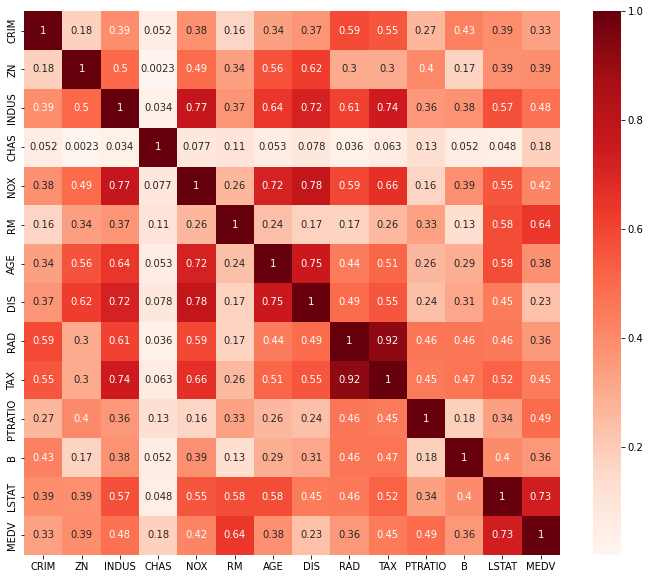

In [3]:
print('\n##########################################')
print('### Calculamos correlaciones')
print('##########################################')

# incorporamos la clase
atrib_y_clase = pd.concat([X_train, y_train], axis=1)

# calculamos la correlación
cor = atrib_y_clase.corr()

# calculamos el valor ansoluto puesto que nos da igual que la correlación sea positiva o negativa
cor_abs = cor.abs()

# mostramos gráficamente
plt.figure(figsize=(12,10))
sns.heatmap(cor.abs(), annot=True, cmap=plt.cm.Reds)
plt.show()

- Aquellos atributos que tengan **correlaciones altas con la clase** ("MEVD" en este caso) serán atributos que claramente **tendrán importancia** a la hora de predecir la clase.

- Cuando un atributo tiene **correlación alta con otros atributo** quiere decir que son **atributos redundantes**, es decir, podríamos quedarnos solo con uno de los dos sin apenas perder información. Eso es algo que pasa con "TAX" y "RAD".

Después de analizar la tabla anterior pordíamos quedarnos con 5 atributos:

In [4]:
print('\n##########################################')
print('### Analizamos las correlaciones,  seleccionamos atributos y evaluamos')
print('##########################################')

elegidas = ['LSTAT', 'RM', 'PTRATIO', 'TAX', 'NOX']

# se crean las nuevas X sólo con los atributos elegidos
X_train_rel = X_train[elegidas]
X_test_rel = X_test[elegidas]

print(X_train_rel.shape)
    
# entrenamos y evaluamos el DecisionTreeRegressor
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### Analizamos las correlaciones,  seleccionamos atributos y evaluamos
##########################################
(354, 5)
MSE = 19.391


Vemos que el error ha aumentado, pero hemos pasado de 13 a 5 atributos.

### 25.1.2 Información mutua, F-value, chi2
La **Información Mutua** de dos variables mide la dependencia entre las variables siendo su valor 0 si las variables son indepedientes y tomando valores mayores a medida que aumenta su dependencia.

En `scikit-learn` exiten dos implementaciones, una para trabajar con conjuntos de datos de regresión (`mutual_info_regression`) y otra en conjuntos de datos de clasificación (`mutual_info_classif`). En ambos casos obtendremos un ranking de atributos en función de su relevancia.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html?highlight=mutual_info_regression#sklearn.feature_selection.mutual_info_regression

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html?highlight=mutual_info#sklearn.feature_selection.mutual_info_classif

Después debemos elegir nosotros los atributos con los que quedarnos. 

Es habitual quedarnos con los $k$ atributos más relevantes (`SelectKBest()`) o con los que comprenda un determinado percentil (`SelectPercentile()`):


In [5]:
print('\n##########################################')
print('### SelectKBest + mutual_info_regression')
print('##########################################')

# creamos el selector indicando que queremos quedarnos con 5 atributos más relevantes
# indicamos también que queremos utilizar 'mutual_info_regression' para obtener la relevancia de los atributos
selector = SelectKBest(mutual_info_regression, k=5)

# entrenamos el selector
selector.fit(X_train, y_train)

print("Atributos seleccionados (%d):" % (selector.get_feature_names_out().shape[0]))
print(selector.get_feature_names_out())

# transformamos los conjuntos de entrenamiento y test
X_train_rel = selector.transform(X_train)
X_test_rel = selector.transform(X_test)

# entrenamos y evaluamos el DecisionTreeRegressor
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### SelectKBest + mutual_info_regression
##########################################
Atributos seleccionados (5):
['INDUS' 'NOX' 'RM' 'PTRATIO' 'LSTAT']
MSE = 19.298


Nos hemos quedado con solo 5 atributos y el error no es demasiado bueno.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectk#sklearn.feature_selection.SelectKBest

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html?highlight=selectpercentile#sklearn.feature_selection.SelectPercentile

Vamos a ver que pasa si nos quedamos con la mitad de los atributos:

In [6]:
print('\n##########################################')
print('### SelectPercentile + mutual_info_regression')
print('##########################################')

# creamos el selector indicando que queremos quedarnos con el 50% de los atributos más relevantes
# indicamos también que queremos utilizar 'mutual_info_regression' para obtener la relevancia de los atributos
selector = SelectPercentile(mutual_info_regression, percentile=50)

# entrenamos el selector
selector.fit(X_train, y_train)

print("Atributos seleccionados (%d):" % (selector.get_feature_names_out().shape[0]))
print(selector.get_feature_names_out())

# transformamos los conjuntos de entrenamiento y test
X_train_rel = selector.transform(X_train)
X_test_rel = selector.transform(X_test)

# entrenamos y evaluamos el DecisionTreeRegressor
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### SelectPercentile + mutual_info_regression
##########################################
Atributos seleccionados (6):
['INDUS' 'NOX' 'RM' 'TAX' 'PTRATIO' 'LSTAT']
MSE = 22.296


No hemos mejorado. 

Lo normal es mejorar a medida que vamos aumentando el número de atributos, aunque a veces pueden suceder situaciones como esta, que puede ser debida por ejemplo a un sobreajuste.

Puede haber un punto en el que si se sigue aumentando el número de atributos el rendimiento empeore cada vez más. Esto es un claro signo de que hay atributos irrelevantes y que al incorporarlos se daña al modelo.

Además de la Información Mutua, existen otros métodos estadísticos populares para calcular la relevancia de los atributos:
- `f_classif` y `f_regression`, que calculan el F-value (Análisis de Varianza (ANOVA) y la Prueba F)
- `chi2`, que calcula distribución $\chi^2$ o distribución de Pearson. Este método solo debe utilizarse si los atributos contienen sólo valores no negativos, como pueden ser frecuencias (por ejemplo, número de veces que aparece una palabra en un documento) o valores booleanos (0 y 1)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html?highlight=chi2#sklearn.feature_selection.chi2


## 25.2 Wrapper Methods
Lo métodos de envoltura (wrapper) son aquellos que realizan los siguientes pasos:
1. entrenan un sistema base
2. analizan los coeficientes de cada atributo tras el entrenamiento
3. se desprenden del atributo o atributos menos importantes 
4. vuelven al paso 1 y repiten el proceso hasta que no queden atributos

De esta forma generan un ranking de atributos.

### 25.2.1 RFE

El algoritmo RFE (Recursive Feature Elimination) es uno de los más populares y podemos utilizarlo mediante la clase `RFE`:


In [7]:
print('\n##########################################')
print('### RFE')
print('##########################################')

# creamos el RFE indicando que queremos quedarnos con 5 atributos y que queremos que quite 1 atributo en cada paso
selector = RFE(LinearRegression(), n_features_to_select=5, step=1)

# entrenmos
selector.fit(X_train, y_train)

print("Atributos seleccionados (%d):" % (selector.get_feature_names_out().shape[0]))
print(selector.get_feature_names_out())

# transformamos los conjuntos de entrenamiento y test
X_train_rel = selector.transform(X_train)
X_test_rel = selector.transform(X_test)

# entrenamos y evaluamos el DecisionTreeRegressor
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### RFE
##########################################
Atributos seleccionados (5):
['CHAS' 'NOX' 'RM' 'DIS' 'PTRATIO']
MSE = 17.504


Como sistema base hemos utilizado una regresión logística.

No valen todos los sistemas, únicamente se pueden utilizar aquellos que tengan el campo `coef_` o el campo `feature_importance_`.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE

### 25.2.2 RFECV
En el anterior ejemplo hemos tenido que seleccionar nosotros el número de atributos deseado, pero no tenemos por qué conocerlo. Una solución a este problema es realizar una validación cruzada cada vez que se elimina un atributo y quedarnos con el conjunto de atributos que ofrezca un mejor rendimiento en la validación cruzada.

Esto podemos hacerlo con `RFECV`: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html


In [8]:
print('\n##########################################')
print('### RFECV')
print('##########################################')

# se crea un generador de folds partiendo el conjunto en 5 trozos
folds = KFold(n_splits=5, shuffle=True, random_state=1234)

# creamos un RFECV de 5 folds
selector = RFECV(LinearRegression(), step=1, cv=folds)

# entrenamos el selector
selector.fit(X_train, y_train)

print("Atributos seleccionados (%d):" % (selector.get_feature_names_out().shape[0]))
print(selector.get_feature_names_out())

# transformamos los conjuntos de entrenamiento y test
X_train_rel = selector.transform(X_train)
X_test_rel = selector.transform(X_test)

# entrenamos y evaluamos  el DecisionTreeRegressor
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### RFECV
##########################################
Atributos seleccionados (13):
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
MSE = 13.499



Hemos obtenido un buen rendimiento pero ¡nos hemos quedado con todos los atributos!. Parece que en este conjunto de datos todos los atributos aportan algo a la solución.

Cuando tenemos pocos atributos en el conjunto original puede ocurrir esto, sin embargo, cuando tenemos muchos atributos en el conjunto de partida lo más habitual es que se seleccione un subconjunto reducido de los mismos.

En esta práctica estamos utilizando un conjunto con pocos atributos para que no se alarge el tiempo de ejecución, pero puedes probar a utilizar algún conjunto con más atributos.

## 25.3 Embedded Methods
Algunos sistemas son capaces de seleccionar los atributos a la vez que entrenan un modelo capaz de resolver la tarea correspondiente. Estos métodos de selección se conocen como embebidos por razones obvias.

### 25.3.1 Lasso (Least Absolute Shrinkage and Selection Operator)
El más popular de todos ellos es el LASSO.

Hemos visto varios algoritmos que introducían un término de regularización durante el aprendizaje tratando de minimizar la norma l2 del vector de coeficientes que estaban aprendiendo $\left( \sum_{i=1}^d w_i^2\right)$. Si en lugar de minimizar la norma l2 le indicamos al algoritmo que el término de regularización debe ser la norma l1 $\left( \sum_{i=1}^d |w_i|\right)$, entonces ya estamos aplicando el método de selección LASSO.

Introducir la norma l1 como regularizador provoca que en su afán por minimizar ese sumatorio los atributos menos relevantes lleven su $w_i$ a 0.

Como verás, esta opción de regularización mediante la norma l1 solo está disponible para aquellos algoritmos que de alguna manera están aprendiendo un vector $w$. Además, en los problemas multiclase, si se sigue la filosofía *one-vs-rest* se tendrá un $w$ por cada clase, con lo que se dificulta la selección de atributos.

Para problemas de regresión, contamos con la clase `Lasso`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [9]:
print('\n##########################################')
print('### LASSO')
print('##########################################')

# entrenamos
sys = Lasso(alpha=1)
sys.fit(X_train, y_train)


print("Coeficientes:", sys.coef_)
seleccionados = sys.feature_names_in_[abs(sys.coef_)>0.00001]
print("Atributos seleccionados (%d):" % len(seleccionados))
print(seleccionados)

# se evalúa el rendimiento del Lasso
y_pred = sys.predict(X_test)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### LASSO
##########################################
Coeficientes: [-0.04350451  0.07490082 -0.02814291  0.         -0.          0.
  0.02142667 -0.83276743  0.31684399 -0.01733131 -0.75868057  0.00850409
 -0.77716059]
Atributos seleccionados (10):
['CRIM' 'ZN' 'INDUS' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']
MSE = 32.265


Prueba a aumentar el valor de `alpha` y verás cómo más atributos llevan su coeficient ($w_i$) a 0.

El error que se obtiene no es el mejor, pero este es un sistema que busca soluciones lineales y tal vez este conjunto no se puede resolver de forma lineal. En estos casos podríamos utilizar `PolinomialFeatures` para generar combinaciones no lineales de la variables y después aplicar `Lasso` pero estaríamos perdiendo un poco el foco puesto que quería reducir atributos, ¡no aumentarlos!

Si quisiésemos, podríamos utilizar `Lasso` únicamente para identificar los atributos descartables y posteriormente entrenar con otro algoritmo el modelo final. Para ello podemos apoyarnos en la función `SelectFromModel()` que nos permite fijar un umbral para descartar atrubutos: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel


In [10]:
print('\n##########################################')
print('### LASSO + SelectFromModel')
print('##########################################')

# se crea un SelectFromModel con umbral casi 0
selector = SelectFromModel(Lasso(alpha=1), threshold=1e-5)

# se entrena
selector.fit(X_train, y_train)

print("Atributos seleccionados (%d):" % (selector.get_feature_names_out().shape[0]))
print(selector.get_feature_names_out())

# transformamos los conjuntos de entrenamiento y test
X_train_rel = selector.transform(X_train)
X_test_rel = selector.transform(X_test)

# entrenamos y evaluamos un árbol con las variables seleccionadas utilizando Lasso
sys = DecisionTreeRegressor(random_state=1234)
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### LASSO + SelectFromModel
##########################################
Atributos seleccionados (10):
['CRIM' 'ZN' 'INDUS' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']
MSE = 25.775


### 25.3.2 RandomForest
Otro ejemplo de sistema de selección embebido es el que tienen los Random Forest. 

Durante su entrenamiento crean decenas o cientos de árboles de decisión y en cada uno intervienen unos determinados atributos. Finalmente, se asigna una relevancia a cada uno de los atributos en función de esas intervenciones. Las relevancias serán valores entre 0 y 1 y la suma de todas ellas debe ser 1.

Ya habíamos visto en la práctica correspondiente que tras entrenar un Random Forest estas relevancias quedan almacenadas en el vector `feature_importances_`:

In [11]:
print('\n##########################################')
print('### RandomForest')
print('##########################################')

# lo entrenamos y a la vez calcula la relevancia de los atributos
sys = RandomForestRegressor(random_state=1234)
sys.fit(X_train, y_train)

y_pred = sys.predict(X_test)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))

# fijo un umbral de 1/13 porque la suma de las relevancias es 1, así que me quedo con los atributos
# que ganan relevancia sobre la que incialmente tendrían si todos fuesen igual de relevantes
print(sys.feature_importances_)
seleccionados = sys.feature_names_in_[sys.feature_importances_>(1/13)]
print("Atributos que pasan el umbral fijado (%d):" % len(seleccionados))
print(seleccionados)


##########################################
### RandomForest
##########################################
MSE = 9.644
[0.02894358 0.00095666 0.00737335 0.00078886 0.0197497  0.32953828
 0.01517203 0.06795098 0.00301044 0.01155809 0.0191946  0.01301969
 0.48274375]
Atributos que pasan el umbral fijado (2):
['RM' 'LSTAT']


Obtenemos un muy buen resultado.

Si observamos las relevancias, hay dos atributos que destacan sobre los demás y que sobrepasan un umbral que podría ser razonable para decidir con qué atributos quedarnos.

Podemos utilizar `SelectFromModel()` como ya hicimos anteriormente para entrenar otro sistema con las variables más relevante según el RandomForest:

In [12]:
print('\n##########################################')
print('### RandomForest + SelectFromModel')
print('##########################################')

# se crea un SelectFromModel con umbral 1/13
selector = SelectFromModel(RandomForestRegressor(random_state=1234), threshold=(1/13))

# se entrena
selector.fit(X_train, y_train)

print("Atributos seleccionados (%d):" % (selector.get_feature_names_out().shape[0]))
print(selector.get_feature_names_out())

# transformamos los conjuntos de entrenamiento y test
X_train_rel = selector.transform(X_train)
X_test_rel = selector.transform(X_test)

# entrenamos y evaluamos un árbol con las variables seleccionadas utilizando RandomForestRegressor
sys = DecisionTreeRegressor(random_state=1234)
sys.fit(X_train_rel, y_train)
y_pred = sys.predict(X_test_rel)
print("MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))


##########################################
### RandomForest + SelectFromModel
##########################################
Atributos seleccionados (2):
['RM' 'LSTAT']
MSE = 36.847


Como podéis ver, la selección que hicimos fue demasiado agresiva.

Prueba a poner como umbral 0.01 y verás cómo mejora el rendimiento, eso sí, aumentará también el número de atributos seleccionado.

## Ejercicios

1. Carga el conjunto de datos  **optdigits** que viene ya separado en entrenamiento (.tra) y test (.tes). Se trata de un conjunto de clasificación en el que hay 10 clases (se pretende identificar dígitos mediante sus imágenes, consulta el .names)
2. Aplica algún filtro de los vistos y compara con los resultados que se obtendrían utilizando todos los atributos con un árbol y un k-vecinos.
3. Utiliza `RFE` y `RFECV` para ver el rendimiento de los wrapper.
4. Prueba la selección que realiza el RandomForest.

Estos ejercicios no es necesario entregarlos.